In [10]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from yf_utils import _2_split_train_val_test, _3_random_slices, _4_lookback_slices
from yf_utils import _5_perf_ranks, _6_grp_tuples_sort_sum
from myUtils import pickle_load, pickle_dump

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 14)
pd.set_option('display.max_colwidth', 12)
pd.set_option('display.width', 800)

# verbose = False  # True prints more output
verbose = True  # True prints more output

path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"
path_data_dump = path_dir + "VSCode_dump/"
fp_df_close_clean = 'df_close_clean'
fp_df_eval_results = 'df_eval_results'

df_close_clean = pickle_load(path_data_dump, fp_df_close_clean)

In [11]:
# Split df_close_clean into training (df_train), validation (df_val) and test (df_test) set.
# The default split is 0.7, 0.2, 0.1 respectively.

###################################
# df_train, df_val, df_test = _2_split_train_val_test(df_close_clean, s_train=1, s_val=0, s_test=0)
df_train, df_val, df_test = _2_split_train_val_test(df_close_clean)
###################################

len_df_train = len(df_train)
len_df_val = len(df_val)
len_df_test = len(df_test)
print(f'len_df_train: {len_df_train}, len_df_val: {len_df_val}, len_df_test: {len_df_test} ')

len_df_train: 1050, len_df_val: 300, len_df_test: 150 


In [12]:
# if store_results:  # record results to df
# my_cols = ['n_samples', 'days_lookbacks', 'days_eval', 'n_top_syms', 'syms_start', 'syms_end', 'grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'grp(CAGR/UI)_mean/std', 'SPY_CAGR/UI']
df_eval_results = pickle_load(path_data_dump, fp_df_eval_results)

In [13]:
# write run results to df_eval_results
store_results = False
# store_results = True

# number of max lookback tuples to create for iloc start_train:end_train:end_eval
# i.e. number of grp_top_set_syms_n_freq and grp_top_set_syms 
# n_samples = 400  
n_samples = 2

# for training, the number of days to lookback from iloc max-lookback end_train
# days_lookbacks = [15, 30, 60, 120]
# days_lookbacks = [30, 60, 120]
days_lookbacks = [60, 120]
# days_lookbacks = [120]
days_lookbacks.sort()

# number of days from end_train are used to evaluate effectiveness of the training
days_eval = 10  

# number of the most-common symbols from days_lookbacks' performance rankings to keep
# n_top_syms = 5
n_top_syms = 10  

syms_start = 0  #  start index of n_top_syms for evaluation
syms_end = 5  #  end index of n_top_syms for evaluation

create a sets of iloc lookback slices (start_train:end_train:end_eval), where  
end_train - start_train = days_lookback  
end_eval - end_train = days_eval  
for example,  
if given:  
 n_samples = 2  
 days_lookbacks = [30, 60, 120]  
 days_eval = 10  
a possible result is:  
 max_lookback_slices:  
 [(150, 270, 280), (5, 125, 135)]  
 where 270-150=125-5=max(days_lookbacks), 280-270=135-125=days_eval  
 sets_lookback_slices:  
 [[(240, 270, 280), (210, 270, 280), (150, 270, 280)], [(95, 125, 135), (65, 125, 135), (5, 125, 135)]]  
  where in a set, 270-240=days_lookbacks[0], 270-210=days_lookbacks[1], 270-150=days_lookbacks[2]  
  and 270, i.e. end_train, is constant for the set  

In [14]:
# return n_samples slices
max_lookback_slices = _3_random_slices(len_df_train, n_samples=n_samples, days_lookback=max(days_lookbacks), days_eval=days_eval)
# return n_samples * len(days_lookbacks) slices
sets_lookback_slices = _4_lookback_slices(max_slices=max_lookback_slices, days_lookbacks=days_lookbacks, verbose=False)

if verbose:
  print(f'max_lookback_slices:\n{max_lookback_slices}')
  print(f'sets_lookback_slices:\n{sets_lookback_slices}')

max_lookback_slices:
[(766, 886, 896), (481, 601, 611)]
sets_lookback_slices:
[[(826, 886, 896), (766, 886, 896)], [(541, 601, 611), (481, 601, 611)]]


Generate lists, n_samples long, of the highest performance ranked symbols. The performance metrics are: CAGR/UI, CAGR/retnStd, retnStd/UI. n_top_syms of the best performing symbols from each metric are combined. The symbols are sorted by their number of appearances in the combined pool, and are placed in a list. A slice of the best performing symbols is selected by syms_start:syms_end, i.e. top_set_syms_n_freq[syms_start:syms_end].     

The performance metrics are calculated based on slices in sets_lookback_slices.  The first two numbers are ilocs for training. The last two numbers are ilocs for evaluation.

In [15]:
grp_top_set_syms_n_freq = []  # list of lists of top_set_symbols_n_freq, there are n_samples lists in list
grp_top_set_syms = []  # list of lists of top_set_symbols, there are n_samples lists in list
# loop thru lists of tuples of start_train:end_train:end_eval, i.e.
#  [[(887, 917, 927), (857, 917, 927), (797, 917, 927)],
#  [(483, 513, 523), (453, 513, 523), (393, 513, 523)]]
for lb_slices in sets_lookback_slices:
  grp_most_common_syms = []  
  for lb_slice in lb_slices:  # lb_slice, e.g. (246, 276, 286)
    start_train = lb_slice[0]
    end_train = lb_slice[1]
    start_eval = end_train
    end_eval = lb_slice[2]
    lookback = end_train - start_train
    d_eval = end_eval - start_eval

    if verbose:
      print(f'days lookback: {lookback}')
      print(f'lb_slices:     {lb_slices}')
      print(f'lb_slice:      {lb_slice}')
      print(f'days eval:     {d_eval}')    
      print(f'start_train:   {start_train}')
      print(f'end_train:     {end_train}')
      # print(f'start_eval:    {start_eval}')
      # print(f'end_eval:      {end_eval}')`

    _df = df_train.iloc[start_train:end_train]
    perf_ranks, most_common_syms = _5_perf_ranks(_df, n_top_syms=n_top_syms)
    grp_most_common_syms.append(most_common_syms)
    
    if verbose:    
      # 1 lookback of r_CAGR/UI, r_CAGR/retnStd, r_retnStd/UI
      print(f'perf_ranks: {perf_ranks}')  
      # most common symbols of perf_ranks 
      print(f'most_common_syms: {most_common_syms}')     
      # grp_perf_ranks[lookback] = perf_ranks
      print(f'+++ finish lookback slice {lookback} +++\n')

  if verbose:
    print(f'grp_most_common_syms: {grp_most_common_syms}')
    # grp_most_common_syms a is list of lists of tuples of 
    #  the most-common-symbols symbol:frequency cumulated from
    #  each days_lookback  
    print(f'**** finish lookback slices {lb_slices} ****\n')

  # flatten list of lists of (symbol:frequency)
  flat_grp_most_common_syms = [val for sublist in grp_most_common_syms for val in sublist]
  # group symbols from set of days_lookbacks (i.e. lb_slices) and sum frequency of the symbols
  set_most_common_syms = _6_grp_tuples_sort_sum(flat_grp_most_common_syms, reverse=True)
  # get the top few most-frequent symbol:frequency pairs
  top_set_syms_n_freq = set_most_common_syms[0:n_top_syms]
  # get symbols from top_set_syms_n_freq

###################################  
  # top_set_syms = [i[0] for i in top_set_syms_n_freq]
  top_set_syms = [i[0] for i in top_set_syms_n_freq[syms_start:syms_end]]  
###################################  
  
  grp_top_set_syms_n_freq.append(top_set_syms_n_freq)
  grp_top_set_syms.append(top_set_syms)

  if verbose:  
    print(f'top {n_top_syms} ranked symbols and frequency from set {lb_slices}:\n{top_set_syms_n_freq}')
    print(f'top {n_top_syms} ranked symbols from set {lb_slices}:\n{top_set_syms}')  
    print(f'===== finish top {n_top_syms} ranked symbols from days_lookback set {lb_slices} =====\n\n')

days lookback: 60
lb_slices:     [(826, 886, 896), (766, 886, 896)]
lb_slice:      (826, 886, 896)
days eval:     10
start_train:   826
end_train:     886
perf_ranks: {'period-60': {'r_CAGR/UI': array(['OSTK', 'APPS', 'MARA', 'RUN', 'CELH', 'PLUG', 'NVAX', 'VSTO',
       'SOHU', 'SWBI'], dtype=object), 'r_CAGR/retnStd': array(['OSTK', 'APPS', 'MARA', 'RUN', 'PLUG', 'NVAX', 'SOHU', 'VSTO',
       'CELH', 'TSLA'], dtype=object), 'r_retnStd/UI': array(['CELH', 'MUC', 'APPS', 'OSTK', 'WSO', 'UPS', 'QCOM', 'NZF', 'FTSM',
       'BSIG'], dtype=object)}}
most_common_syms: [('OSTK', 3), ('APPS', 3), ('CELH', 3), ('MARA', 2), ('RUN', 2), ('PLUG', 2), ('NVAX', 2), ('VSTO', 2), ('SOHU', 2), ('SWBI', 1), ('TSLA', 1), ('MUC', 1), ('WSO', 1), ('UPS', 1), ('QCOM', 1), ('NZF', 1), ('FTSM', 1), ('BSIG', 1)]
+++ finish lookback slice 60 +++

days lookback: 120
lb_slices:     [(826, 886, 896), (766, 886, 896)]
lb_slice:      (766, 886, 896)
days eval:     10
start_train:   766
end_train:     886
perf_ran

In [16]:
print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
for item in z_grp_top_set_syms:
  print(item)
print('')

z_grp_top_set_syms:
((766, 886, 896), ['APPS', 'CELH', 'OSTK', 'NVAX', 'VSTO'])
((481, 601, 611), ['ENPH', 'FTSM', 'PRO', 'AXSM', 'SHOP'])



In [17]:
from yf_utils import _7_perf_eval

print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
# z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms[26:29])

for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms):
# for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms[26:29]):

  start_train = _lookback_slice[0]
  end_train = _lookback_slice[1]
  start_eval = end_train
  end_eval = _lookback_slice[2]

  print(f'{i + 1 } of {n_samples} max_lookback_slice')
  print(f'max_lookback_slice: {_lookback_slice}')
  # dates correspond to max_lookback_slice
  d_start_train = df_train.index[start_train].strftime('%Y-%m-%d')
  d_end_train = df_train.index[end_train].strftime('%Y-%m-%d')
  d_start_eval = d_end_train
  d_end_eval = df_train.index[end_eval].strftime('%Y-%m-%d')
  d_df_eval_start = d_end_train
  d_df_eval_end = df_train.index[end_eval - 1].strftime('%Y-%m-%d')  
  print(f'max lookback dates: {d_start_train}, {d_end_train}, {d_end_eval}')
  print(f'df_eval dates (inclusive): {d_df_eval_start} - {d_df_eval_end}')    
  print(f'top_set_syms: {_top_set_syms}\n')

  df_eval = df_train[start_eval:end_eval][_top_set_syms]

  if verbose:
    # print(f'start_eval: {start_eval}')
    # print(f'end_eval:   {end_eval}')  
    print(f'start_eval: {start_eval},  date: {d_end_train}')
    print(f'end_eval:   {end_eval},  date: {d_end_eval},  df_eval last date: {d_df_eval_end}')      
    print(f'\ndf_eval:\n{df_eval}\n')


  _, grp_retnStd_d_UI, grp_CAGR_d_retnStd, grp_CAGR_d_UI = _7_perf_eval(df_eval)
  print(f'grp(retnStd/UI):   mean, std, mean/std: {grp_retnStd_d_UI[0]:>13,.3f}, {grp_retnStd_d_UI[1]:>13,.3f}, {grp_retnStd_d_UI[2]:>13,.3f}')
  print(f'grp(CAGR/retnStd): mean, std, mean/std: {grp_CAGR_d_retnStd[0]:>13,.3f}, {grp_CAGR_d_retnStd[1]:>13,.3f}, {grp_CAGR_d_retnStd[2]:>13,.3f}')
  print(f'grp(CAGR/UI):      mean, std, mean/std: {grp_CAGR_d_UI[0]:>13,.3f}, {grp_CAGR_d_UI[1]:>13,.3f}, {grp_CAGR_d_UI[2]:>13,.3f}')

  _sym_idx = ['SPY']
  df_SPY = df_train[start_eval:end_eval][_sym_idx]
  _, SPY_retnStd_d_UI, SPY_CAGR_d_retnStd, SPY_CAGR_d_UI = _7_perf_eval(df_SPY)
  print(f'\nSPY: retnStd/UI, CAGR/retnStd, CAGR/UI: {SPY_retnStd_d_UI[0]:>13,.3f}, {SPY_CAGR_d_retnStd[0]:>13,.3f}, {SPY_CAGR_d_UI[0]:>13,.3f}')

  if store_results:  # record results to df
    row_add = [n_samples, str(days_lookbacks), days_eval, n_top_syms, syms_start, syms_end, grp_CAGR_d_UI[0], grp_CAGR_d_UI[1], grp_CAGR_d_UI[2], SPY_CAGR_d_UI[0]]
    df_eval_results.loc[len(df_eval_results)] = row_add
    print(f'appended row_add to df_eval_results:\n{row_add}\n')
  print('='*50, '\n')  

z_grp_top_set_syms:
1 of 2 max_lookback_slice
max_lookback_slice: (766, 886, 896)
max lookback dates: 2020-02-28, 2020-08-19, 2020-09-02
df_eval dates (inclusive): 2020-08-19 - 2020-09-01
top_set_syms: ['APPS', 'CELH', 'OSTK', 'NVAX', 'VSTO']

start_eval: 886,  date: 2020-08-19
end_eval:   896,  date: 2020-09-02,  df_eval last date: 2020-09-01

df_eval:
                 APPS       CELH        OSTK        NVAX       VSTO
Date                                                               
2020-08-19  27.740000  25.379999  121.760002  147.059998  21.709999
2020-08-20  28.139999  22.879999  122.320000  143.130005  20.820000
2020-08-21  28.040001  21.299999  121.089996  137.619995  20.660000
2020-08-24  25.700001  21.200001  116.239998  119.260002  20.570000
2020-08-25  24.510000  21.299999  112.820000  113.110001  19.740000
2020-08-26  23.670000  21.580000  109.519997  114.620003  20.320000
2020-08-27  22.700001  20.790001   95.989998  107.349998  19.379999
2020-08-28  23.980000  20.540001

In [18]:
# https://towardsdatascience.com/pandas-groupby-a-simple-but-detailed-tutorial-314b8f37005d
# https://towardsdatascience.com/accessing-data-in-a-multiindex-dataframe-in-pandas-569e8767201d
# https://towardsdatascience.com/summarizing-data-with-pandas-crosstab-efc8b9abecf
# https://towardsdatascience.com/how-to-flatten-multiindex-columns-and-rows-in-pandas-f5406c50e569
# https://datascientyst.com/list-aggregation-functions-aggfunc-groupby-pandas/

In [31]:
# df = pickle_load(path_data_dump, 'df_eval_results')
df = df_eval_results.copy()
# display(HTML(df.to_html()))

In [38]:
my_cols = ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'SPY_CAGR/UI']
# my_cols = ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std']
# my_cols = ['SPY_CAGR/UI']
_df = df[my_cols]
row_inf = _df.index[np.isinf(_df).any(axis=1)]
print(f'row iloc with inf:\n{row_inf}')
print(f'len(row iloc with inf):\n{len(row_inf)}')
print(f'len(_df): {len(_df)}')
# df_inf = df.iloc[row_inf].copy()  # df with inf in my_cols
# # display(HTML(df_inf.to_html()))
# df.drop(axis=0, index=row_inf, inplace=True)
# # display(HTML(df.to_html()))
# df.dropna(how='any', inplace=True)
# df

row iloc with inf:
Int64Index([25, 26, 38, 52, 65, 73, 76, 84, 100, 110, 131, 139, 149, 223, 225, 244, 266, 346, 349, 358, 384, 393, 405, 411, 412, 418, 419, 440, 473, 478, 496, 511, 525, 533, 535, 540, 554, 581, 586, 587, 590, 619, 623, 627, 629, 633, 681, 683, 684, 706, 727, 750, 763, 784], dtype='int64')
len(row iloc with inf):
54
len(_df): 800


In [55]:
pd.set_option('display.max_colwidth', 20)
_df
# _df1 = _df.sort_values(by=['grp(CAGR/UI)_mean']).head(100).copy()
_df1 = _df.sort_values(by=['grp(CAGR/UI)_mean']).tail(100).copy()
# display(HTML(_df1.to_html()))
_df1

,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,SPY_CAGR/UI
782,9.062946e+05,2.026488e+06,353.649048
341,9.064245e+05,2.026416e+06,353.649048
41,9.504093e+05,2.124029e+06,568.536322
200,9.504093e+05,2.124029e+06,568.536322
380,1.146512e+06,2.521546e+06,-24.135941
657,1.161077e+06,2.533677e+06,267.613900
189,1.211874e+06,2.709639e+06,33.623753
72,1.211874e+06,2.709639e+06,33.623753
593,1.232342e+06,2.748784e+06,21.174408
789,1.262157e+06,2.814414e+06,-25.186062


In [79]:
# # https://stackoverflow.com/questions/50773107/how-to-replace-infinite-value-with-maximum-value-of-a-pandas-column
# m = df.loc[df['Crime_Rate'] != np.inf, 'Crime_Rate'].max()
# df['Crime_Rate'].replace(np.inf,m,inplace=True)

m = _df1.loc[_df1['grp(CAGR/UI)_mean'] != np.inf, ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std']].max()
print(f'm[0]: {m[0]}')
print(f'm[1]: {m[1]}')
print(f'max grp(CAGR/UI)_mean:  {m["grp(CAGR/UI)_mean"]}')
print(f'max grp(CAGR/UI)_std]:  {m["grp(CAGR/UI)_std"]}')

m[0]: 444907257358.61584
m[1]: 994841359375.5496
max grp(CAGR/UI)_mean:  444907257358.61584
max grp(CAGR/UI)_std]:  994841359375.5496


In [83]:
# _df1['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std'].replace(np.inf,m,inplace=True)
_df1['grp(CAGR/UI)_mean'].replace(np.inf, m['grp(CAGR/UI)_mean'] ,inplace=True)
_df1['grp(CAGR/UI)_std'].replace(np.nan, m['grp(CAGR/UI)_std'],inplace=True)
_df1

,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,SPY_CAGR/UI
25,4.449073e+11,9.948414e+11,-19.905473
26,4.449073e+11,9.948414e+11,765.486997
38,4.449073e+11,9.948414e+11,28.844500
41,9.504093e+05,2.124029e+06,568.536322
55,1.674059e+06,3.742525e+06,16.705736
57,2.448875e+07,5.475800e+07,1042.699556
59,4.449073e+11,9.948414e+11,90.105169
65,4.449073e+11,9.948414e+11,6.717283
66,2.448875e+07,5.475800e+07,1042.699556
72,1.211874e+06,2.709639e+06,33.623753


In [66]:
_df1.loc[:, ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std']]
_df1.sort_index(inplace=True)
_df1

,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,SPY_CAGR/UI
25,inf,NaN,-19.905473
26,inf,NaN,765.486997
38,inf,NaN,28.844500
41,9.504093e+05,2.124029e+06,568.536322
55,1.674059e+06,3.742525e+06,16.705736
57,2.448875e+07,5.475800e+07,1042.699556
59,4.449073e+11,9.948414e+11,90.105169
65,inf,NaN,6.717283
66,2.448875e+07,5.475800e+07,1042.699556
72,1.211874e+06,2.709639e+06,33.623753


In [71]:
m = _df1.loc[:, ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std']].max()
m

grp(CAGR/UI)_mean             inf
grp(CAGR/UI)_std     9.948414e+11
dtype: float64

In [20]:
my_cols = ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'SPY_CAGR/UI']
_df = df[my_cols]
row_inf = _df.index[np.isinf(_df).any(axis=1)]
print(f'row iloc with inf:\n{row_inf}\n')
df_inf = df.iloc[row_inf].copy()  # df with inf in my_cols
# display(HTML(df_inf.to_html()))
df.drop(axis=0, index=row_inf, inplace=True)
# display(HTML(df.to_html()))
df.dropna(how='any', inplace=True)
df

row iloc with inf:
Int64Index([25, 26, 38, 52, 65, 73, 76, 84, 100, 110, 131, 139, 149, 223, 225, 244, 266, 346, 349, 358, 384, 393, 405, 411, 412, 418, 419, 440, 473, 478, 496, 511, 525, 533, 535, 540, 554, 581, 586, 587, 590, 619, 623, 627, 629, 633, 681, 683, 684, 706, 727, 750, 763, 784], dtype='int64')



,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30,...",10,10,0,5,248.489978,584.843540,0.424883,-30.375669
1,400,"[15, 30,...",10,10,0,5,31.927844,60.229337,0.530105,-10.581483
2,400,"[15, 30,...",10,10,0,5,4008.399882,5423.419446,0.739091,190.881313
3,400,"[15, 30,...",10,10,0,5,3735.447231,8000.658763,0.466892,289.043187
4,400,"[15, 30,...",10,10,0,5,-6.004549,16.475508,-0.364453,-12.457626
...,...,...,...,...,...,...,...,...,...,...
795,400,"[30, 60,...",10,10,0,5,33229.34...,71736.37...,0.463215,53.836188
796,400,"[30, 60,...",10,10,0,5,22.390279,82.528456,0.271304,-18.271479
797,400,"[30, 60,...",10,10,0,5,569.693718,1270.879342,0.448267,657.333386
798,400,"[30, 60,...",10,10,0,5,2093.482297,4283.497196,0.488732,-7.457301


In [21]:
# pd.crosstab(df['days_lookbacks'], df['grp(CAGR/UI)_mean'])
tbl = df.groupby(['days_lookbacks'])\
        .agg({'grp(CAGR/UI)_mean': ['mean', 'std'],
              'grp(CAGR/UI)_mean/std': ['mean', 'std'],
              'SPY_CAGR/UI': ['mean', 'std']})

In [22]:
tbl

grp(CAGR/UI)_mean              grp(CAGR/UI)_mean/std           SPY_CAGR/UI            
                          mean          std                  mean       std        mean         std
days_look...                                                                                       
[15, 30, ...  3.579270...       3.953039...     0.216957           1.438915  268.776613  682.682971
[30, 60, ...  2.215328...       2.629466...     0.257756           0.997108  266.594045  675.322106

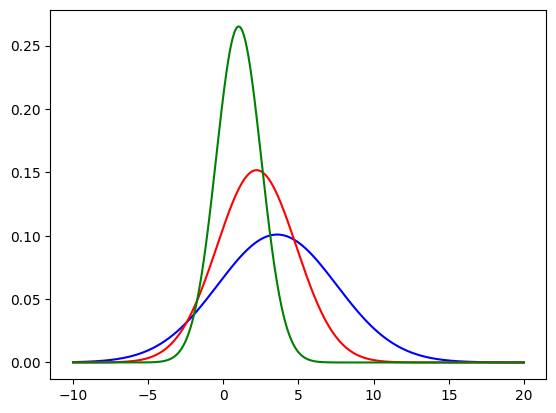

In [23]:
import pylab
import numpy as np
from scipy.stats import norm
x = np.linspace(-10,20,1000)
y = norm.pdf(x, loc=3.579270, scale=3.953039)    # for example
z = norm.pdf(x, loc=2.215328, scale=2.629466)    # for example
z1 = norm.pdf(x, loc=1.021825, scale=1.505096)    # for example
pylab.plot(x,y, 'b')
pylab.plot(x,z, 'r')
pylab.plot(x,z1, 'g')
pylab.show()

In [26]:
print(f'n_samples:             {n_samples:>13}')
print(f'days_lookbacks:        {days_lookbacks}')
print(f'days_eval:             {days_eval:>13}')
print(f'n_top_syms:            {n_top_syms:>13}')
print(f'syms_start:            {syms_start:>13}')
print(f'syms_end:              {syms_end:>13}')
print(f'grp(CAGR/UI)_mean:     {grp_CAGR_d_UI[0]:>13,.3f}')
print(f'grp(CAGR/UI)_std:      {grp_CAGR_d_UI[1]:>13,.3f}')
print(f'grp(CAGR/UI)_mean/std: {grp_CAGR_d_UI[2]:>13,.3f}')
print(f'SPY_CAGR/UI:           {SPY_CAGR_d_UI[0]:>13,.3f}')

n_samples:                         2
days_lookbacks:        [60, 120]
days_eval:                        10
n_top_syms:                       10
syms_start:                        0
syms_end:                          5
grp(CAGR/UI)_mean:               inf
grp(CAGR/UI)_std:                nan
grp(CAGR/UI)_mean/std:           nan
SPY_CAGR/UI:                 -19.905
